# Is humanity's gluttony killing the planet?

With rising life expectancies and a rapid increase in population across the globe, it is getting harder for humanity to sustain its nutritional needs. The inefficient upscale of food production is having a noticeable negative impact on the planet. Deforestation, increased livestock farming, and the excessive use of fertilisers, which are all related to food production, are the main causal factors behind rising emissions in greenhouse gasses and consequently, global warming. In an effort to further the advancements in battling climate change, we aim to reveal how food production and its necessary resources have evolved, and the relation to global warming. We will do so by carrying out an analysis of the data published by the Food and Agriculture Organization of the United Nations (FAOSTAT). We believe that by doing so, we could potentially increase general public awareness of this topic and compel people to keep the stated issue in mind when acting as consumers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

### How has the world recenlty evolved in terms of factors that are relevant to agriculture and climate change?

As an introductory section to this topic, we will explore how various factors that are related to climate change have evolved in recent years and how humanity's agricultural activity contributes to these.

#### Population

First of all, we load the data illustrating the population levels across the world.

In [3]:
population_df = pd.read_csv('data/Population_E_All_Data_(Normalized).zip', encoding='latin-1')
population_df.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1950,1950,1000 persons,7752.118,X,NaN
1,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1951,1951,1000 persons,7840.156,X,NaN
2,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1952,1952,1000 persons,7935.997,X,NaN
3,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1953,1953,1000 persons,8039.694,X,NaN
4,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1954,1954,1000 persons,8151.317,X,NaN


In [4]:
world_population = population_df[population_df.Area=='World'][['Area', 'Year', 'Element', 'Unit', 'Value']]
food_importing_population = population_df[population_df.Area=='Net Food Importing Developing Countries']\
[['Year', 'Element', 'Value']]
food_deficit_population = population_df[population_df.Area=='Low Income Food Deficit Countries']\
[['Year', 'Element', 'Value']]

In [5]:
food_importing_population = food_importing_population.rename(columns={'Value': 'num_people_imp_countries'})
food_deficit_population = food_deficit_population.rename(columns={'Value': 'num_people_def_countries'})

In [6]:
world_population = pd.merge(world_population, food_importing_population, on=['Year', 'Element'], how='inner')
world_population = pd.merge(world_population, food_deficit_population, on=['Year', 'Element'], how='inner')

In [7]:
world_population['ratio_imp_pop'] = world_population.num_people_imp_countries/world_population.Value
world_population['ratio_def_pop'] = world_population.num_people_def_countries/world_population.Value

In [8]:
world_population = world_population[(world_population.Year<2018) 
                                    & (world_population.Element=='Total Population - Both sexes')]

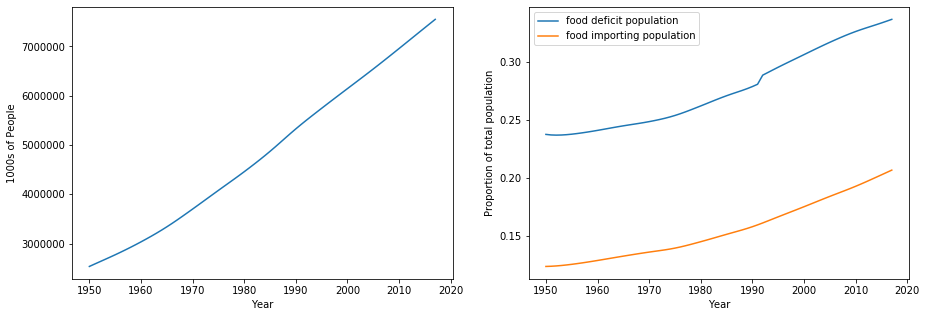

In [9]:
fig = plt.figure(figsize=(15,5))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.plot(world_population.Year.values, world_population.Value.values)
p1.set_xlabel('Year')
p1.set_ylabel('1000s of People')
p2.plot(world_population.Year.values, world_population.ratio_def_pop.values, label='food deficit population')
p2.plot(world_population.Year.values, world_population.ratio_imp_pop.values, label='food importing population')
p2.set_xlabel('Year')
p2.set_ylabel('Proportion of total population')
p2.legend()
plt.show()

We can clearly observe that the overall population level of the planet has significantly increased over the past 60 years (going roughly from 2.5 to 7.5 billion). Alongside this, we notice that the proportion of the total population that reside in countries that are either low income food deficit or net food importing countries is also on the rise. This highlights the fact that there is a greater number of humans that rely on limited food production resources.

While processing the data above, we noticed that different levels of aggregation (countries, continents, etc.) are represented as separate rows. In order to obtain the mapping between continents and countries, which will be useful throughout our analysis, we downloaded this information from the FAOSTAT website (as it was not available in the original datasets) and integrated it with the populations data.

In [11]:
country_metadata = pd.read_csv('data/FAOSTAT_data_11-19-2019.csv')
country_metadata.head()

,Country Group Code,Country Group,Country Code,Country,M49 Code,ISO2 Code,ISO3 Code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,233,Burkina Faso,854.0,BF,BFA


In [12]:
countries = country_metadata.Country.drop_duplicates().values
continents = country_metadata[(country_metadata['Country Group Code']>5000) & (country_metadata['Country Group Code']%100==0)]
continents = continents['Country Group'].drop_duplicates().values

In [13]:
country_populations = population_df[(population_df.Area.isin(countries)) 
                                    & (population_df.Element=='Total Population - Both sexes')].copy()
country_populations['Population'] = country_populations.Value * 1000
country_populations = country_populations[['Area', 'Year', 'Population']]

In [14]:
country_to_group = country_metadata[['Country Group', 'Country']]

In [15]:
new_population_df = pd.merge(country_populations, country_to_group, 
                            left_on='Area', right_on='Country')
new_population_df = new_population_df[['Year', 'Country Group', 'Country', 'Population']]

In [16]:
new_population_df.head()

,Year,Country Group,Country,Population
0,1950,Asia,Afghanistan,7752118.0
1,1950,Land Locked Developing Countries,Afghanistan,7752118.0
2,1950,Least Developed Countries,Afghanistan,7752118.0
3,1950,Low Income Food Deficit Countries,Afghanistan,7752118.0
4,1950,Net Food Importing Developing Countries,Afghanistan,7752118.0


#### Evolution of temperature levels

Secondly, we visualise the evolution of the average yearly temperature levels.

In [18]:
temperatures_df = pd.read_csv('data/Environment_Temperature_change_E_All_Data_(Normalized).zip', 
                           encoding='latin-1')
temperatures_df.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,7001,January,7271,Temperature change,1961,1961,°C,0.993,Fc
1,2,Afghanistan,7001,January,7271,Temperature change,1962,1962,°C,0.137,Fc
2,2,Afghanistan,7001,January,7271,Temperature change,1963,1963,°C,2.441,Fc
3,2,Afghanistan,7001,January,7271,Temperature change,1964,1964,°C,-5.359,Fc
4,2,Afghanistan,7001,January,7271,Temperature change,1965,1965,°C,2.211,Fc


In [23]:
world_temperatures_changes = temperatures_df[(temperatures_df.Area=='World') 
                                             & (temperatures_df.Months=='Meteorological year') 
                                             & (temperatures_df.Element=='Temperature change') ]

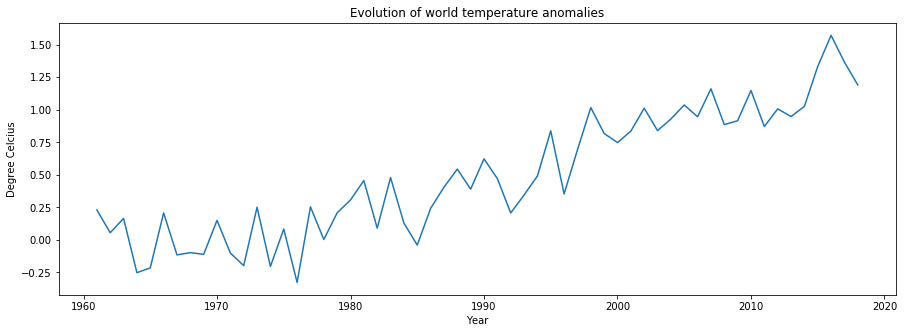

In [24]:
plt.figure(figsize=(15,5))
plt.plot(world_temperatures_changes.Year.values, world_temperatures_changes.Value.values)
plt.title('Evolution of world temperature anomalies')
plt.xlabel('Year')
plt.ylabel('Degree Celcius')
plt.show()

Temperature anomalies (i.e. the Value column) indicate how much warmer or colder it is than normal for a particular place and time. Normal always means the average over the 30-year period 1951-1980 for that place and time of year. The increasing trend in temperature is apparent looking only at the data since 1960. These are related to the greenhouse gas emissions that we investigate next.

#### Greenhouse Gas Emissions

In [25]:
emissions_by_sector_df = pd.read_csv('data/Environment_Emissions_by_Sector_E_All_Data_(Normalized).zip', 
                                  encoding='latin-1')

In [27]:
agriculture_emissions_df = pd.read_csv('data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).zip', 
                                       encoding='latin-1')

In [28]:
emissions_world_sectors = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                & (emissions_by_sector_df.Area=='World')
                                                & (emissions_by_sector_df.Year==emissions_by_sector_df.Year.max())]

In [29]:
sectors = ['Energy (energy, manufacturing and construction industries and fugitive emissions)', 'Transport', 
           'Residential, commercial, institutional and AFF', 'Industrial processes and product use', 'Waste', 
           'Other sources', 'International bunkers', 'Agriculture total', 'Land use sources']

The above list of sectors was taken from [FAOSTAT official documentation](http://fenixservices.fao.org/faostat/static/documents/EM/EM_e.pdf)

In [30]:
p = emissions_world_sectors[emissions_world_sectors.Item.isin(sectors)]

In [31]:
world_ag_emissions_hist = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                 & (emissions_by_sector_df.Area=='World')
                                                 & (emissions_by_sector_df.Item=='Agriculture total')]

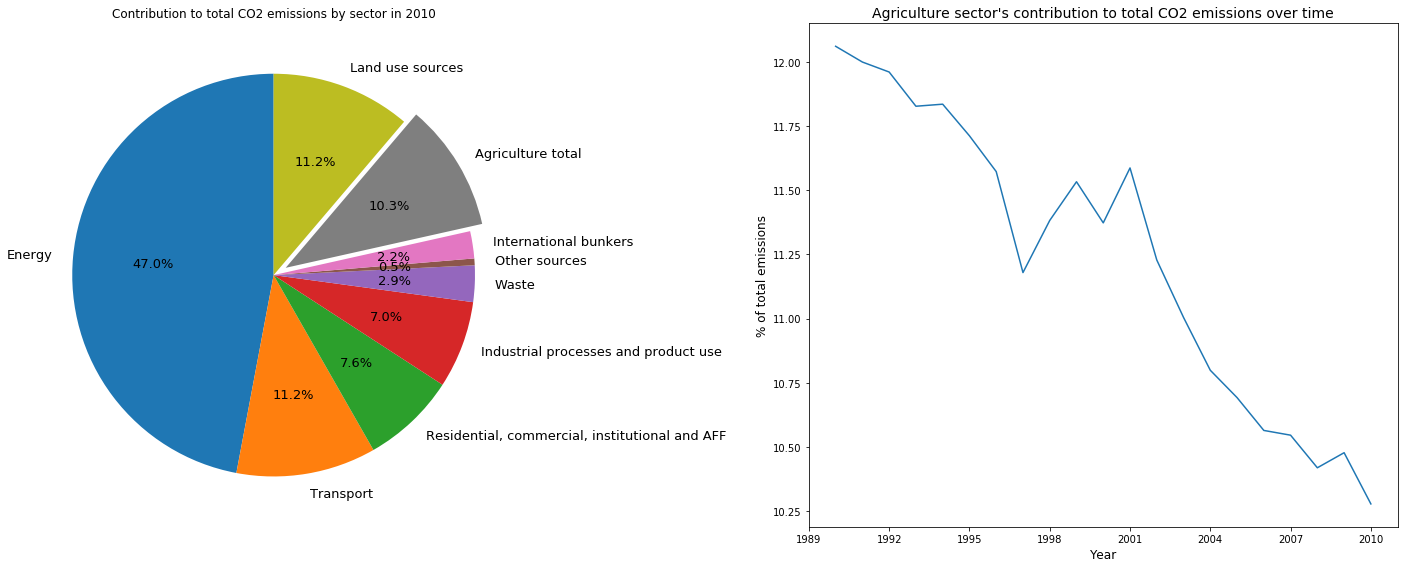

In [32]:
fig = plt.figure(figsize=(20,8))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
sector_labels = sectors.copy()
sector_labels[0] = 'Energy'
p1.pie(p.Value.values, explode=[0,0,0,0,0,0,0,0.07,0], labels=sector_labels, autopct='%1.1f%%', startangle=90, 
       textprops={'fontsize': 13})
p1.set_title('Contribution to total CO2 emissions by sector in ' + str(p.Year.max()), fontsize=12)
p2.plot(world_ag_emissions_hist.Year.values, world_ag_emissions_hist.Value.values)
p2.set_xlabel('Year', fontsize=12)
p2.set_ylabel('% of total emissions', fontsize=12)
p2.xaxis.set_major_locator(MaxNLocator(integer=True))
p2.set_title("Agriculture sector's contribution to total CO2 emissions over time", fontsize=14)
plt.tight_layout(w_pad=1)
plt.show()

From the pie plot above we can see that agriculture represents a sizeable proportion of total CO2 emissions (about 10%). Note that the biggest proportion of emissions comes from energy (energy, manufacturing and construction industries and fugitive emissions). Although we see that agriculture's share of emissions has decresead over the years (roughly from 12% to 10%), this could be potentially caused by the increase of another sector's share. We explore the evolution of the actual emissions from the agricultural sector below.

In [38]:
agriculture_emissions_df.Element.drop_duplicates()

0                 Emissions (CH4)
59              Emissions (CO2eq)
118    Emissions (CO2eq) from CH4
354    Emissions (CO2eq) from N2O
413               Emissions (N2O)
Name: Element, dtype: object

In [45]:
world_agriculture_emissions = agriculture_emissions_df[(agriculture_emissions_df.Area=='World') 
                                                       & ~(agriculture_emissions_df.Element.isin(['Emissions (CO2eq)', 'Emissions (CH4)', 'Emissions (N2O)']))
                                                       & (agriculture_emissions_df.Item=='Agriculture total')
                                                       & (agriculture_emissions_df.Year<2018)]

In [46]:
xticks = world_agriculture_emissions.Year.drop_duplicates().sort_values().values
labels = world_agriculture_emissions.Element.drop_duplicates().values

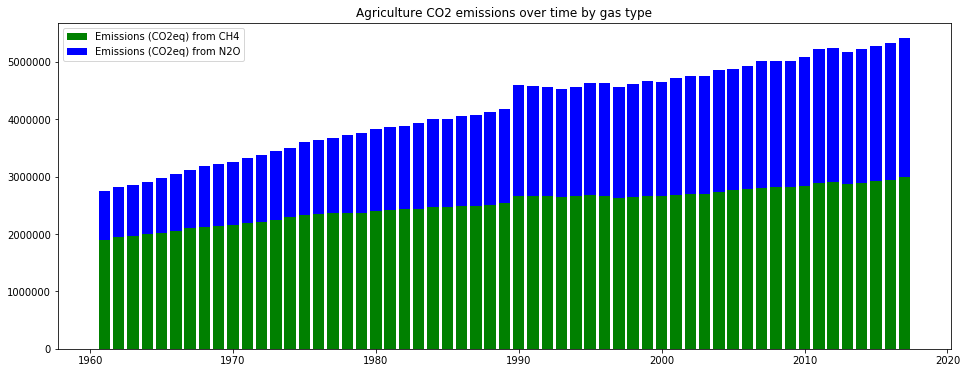

In [47]:
plt.figure(figsize=(16,6))
p1 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[0]].Value.values, 
             color='g', label=labels[0])
p2 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             bottom=world_agriculture_emissions[world_agriculture_emissions.Element==labels[0]].Value.values, 
             color='b', label=labels[1])
plt.legend()
plt.title('Agriculture CO2 emissions over time by gas type')
plt.show()

# THOMAS

In [48]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [50]:
# Path to raw data
data_path = 'data/'

In [51]:
def select_keywords_related_files(data_path, key_words):
    filenames = [filename for filename in os.listdir(data_path)]
    environment_filenames = list(filter(lambda filename: any(key_word in filename for key_word in key_words), filenames))
    environment_filepaths = list(map(lambda filename: os.path.join(data_path, filename), environment_filenames))
    return environment_filepaths

In [52]:
populations_df = pd.read_csv('data/Population_E_All_Data_(Normalized).zip', encoding='latin-1')
print(populations_df.Element.unique())
print(populations_df.Item.unique())
populations_df['is_country'] = populations_df['Area Code'].apply(lambda code: len(str(code)) < 4)
populations_df = population_df[(population_df.Element == 'Total Population - Both sexes') & (populations_df.is_country)
                               & (populations_df.Year == 2014) & (populations_df.Area != 'China, mainland')]
populations_df = populations_df[['Area', 'Value']].sort_values(by='Value', ascending=False)
populations_df = populations_df.rename(columns={'Value': 'Population'})

['Total Population - Both sexes' 'Total Population - Male'
 'Total Population - Female' 'Rural population' 'Urban population']
['Population - Est. & Proj.']


In [53]:
# Select all files which are related to climate change
emissions_paths = select_keywords_related_files(data_path, key_words=['Emissions'])
emissions_paths

['data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).zip',
 'data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip',
 'data/Environment_Emissions_by_Sector_E_All_Data_(Normalized).zip']

In [55]:
emissions_df = pd.read_csv('data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip', encoding='latin-1')
#emissions_df = pd.read_csv(emissions_paths[-6], encoding='latin-1')
print(emissions_df.Element.unique())
print(emissions_df.Item.unique())
print(emissions_df.Year.max())
emissions_df[emissions_df.Element == 'Emissions (CO2eq)']

['Emissions intensity' 'Emissions (CO2eq)' 'Production']
['Cereals excluding rice' 'Rice, paddy' 'Meat, cattle'
 'Milk, whole fresh cow' 'Meat, goat' 'Milk, whole fresh goat'
 'Meat, sheep' 'Milk, whole fresh sheep' 'Milk, whole fresh camel'
 'Meat, chicken' 'Eggs, hen, in shell' 'Milk, whole fresh buffalo'
 'Meat, pig' 'Meat, buffalo']
2016


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
56,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1961,1961,gigagrams,402.2165,Fc
57,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1962,1962,gigagrams,408.3269,Fc
58,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1963,1963,gigagrams,385.7396,Fc
59,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1964,1964,gigagrams,406.7923,Fc
60,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1965,1965,gigagrams,410.0940,Fc
...,...,...,...,...,...,...,...,...,...,...,...
376370,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2012,2012,gigagrams,67724.7956,A
376371,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2013,2013,gigagrams,66945.8132,A
376372,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2014,2014,gigagrams,69130.9316,A
376373,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2015,2015,gigagrams,70005.9504,A


In [56]:
emissions_df['is_country'] = emissions_df['Area Code'].apply(lambda code: len(str(code)) < 4)
emissions_country = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.is_country)]
emissions_country_total = emissions_country[emissions_country.Year == 2014][['Area', 'Value']]\
    .groupby('Area', as_index=False).agg('sum').sort_values(by='Value', ascending=False)
emissions_country_total

,Area,Value
38,China,578982.4331
42,"China, mainland",575316.9288
91,India,550253.5783
24,Brazil,407380.3308
206,United States of America,303450.8525
...,...,...
133,Nauru,1.2146
193,Tokelau,0.4189
118,Maldives,0.3593
164,Saint Pierre and Miquelon,0.1673


In [57]:
emissions_normalized = emissions_country_total.merge(populations_df, how='inner')
emissions_normalized['Normalized Emissions'] = emissions_normalized.Value / (1000 * emissions_normalized.Population)
emissions_normalized.sort_values(by='Normalized Emissions', ascending=False).head(30)

,Area,Value,Population,Normalized Emissions
165,Falkland Islands (Malvinas),140.9004,2.792,0.050466
25,New Zealand,36622.1847,4567.527,0.008018
35,Uruguay,23645.1887,3400.436,0.006954
52,Mongolia,15022.5486,2940.108,0.005110
186,Montserrat,20.8016,4.957,0.004196
7,Australia,96156.9822,23596.424,0.004075
33,Paraguay,25842.6450,6599.526,0.003916
47,Ireland,17351.8117,4626.844,0.003750
6,Argentina,100862.7685,42637.511,0.002366
37,South Sudan,23501.9858,10554.880,0.002227


In [59]:
emissions_country = emissions_country[['Area', 'Item', 'Value']].groupby(['Area', 'Item'], as_index=False).agg('mean')
emissions_country = emissions_country.sort_values('Value', ascending=False).groupby(['Area'], as_index=False).first()
#emissions_country.sort_values(by='Value', ascending=False).rename(columns={'Value': })

In [60]:
continents_ = ['Africa', 'Asia', 'Americas', 'Europe', 'Oceania']

In [61]:
world_emissions_intensity = emissions_df[(emissions_df.Element == 'Emissions intensity') & (emissions_df.Area == 'World')]
items = world_emissions_intensity.Item.unique().tolist()
meat = list(filter(lambda x: 'Meat' in x, items))
milk = list(filter(lambda x: 'Milk' in x, items))
remaining = list(set(items) - set(meat + milk))

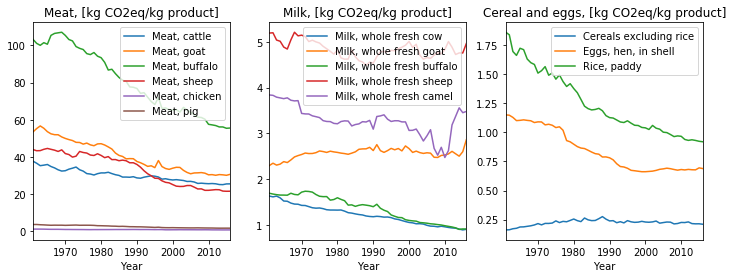

In [62]:
world_emissions_intensity = world_emissions_intensity[['Item', 'Year', 'Value']].groupby(['Item', 'Year'], as_index=False).agg('mean')
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for item in meat:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[0], label=item)
    axes[0].legend()
    axes[0].set_title('Meat, [kg CO2eq/kg product]')
for item in milk:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[1], label=item)
    axes[1].legend()
    axes[1].set_title('Milk, [kg CO2eq/kg product]')
for item in remaining:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[2], label=item)
    axes[2].legend()
    axes[2].set_title('Cereal and eggs, [kg CO2eq/kg product]')

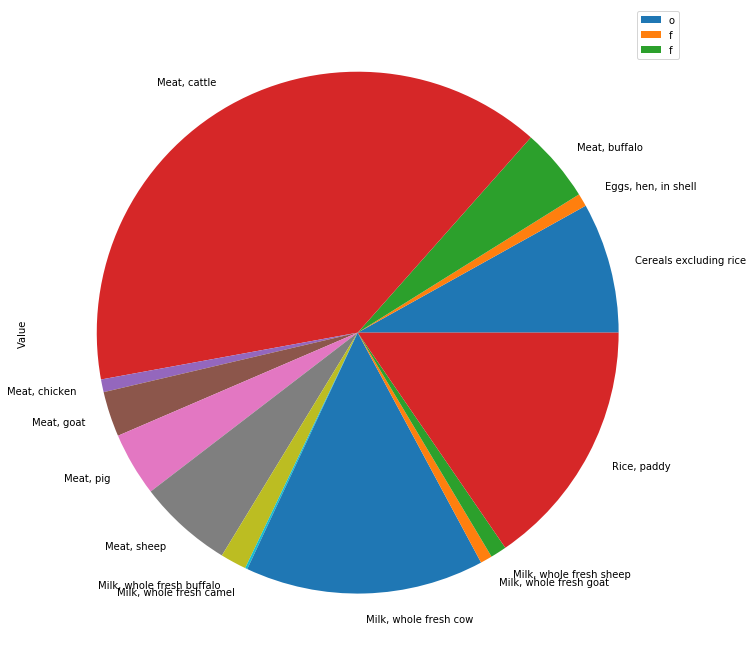

In [63]:
fig, ax = plt.subplots(figsize=(12, 12))
world_net_emissions = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.Area == 'World')]
world_net_emissions[['Item', 'Value']].groupby('Item').agg('sum').plot.pie(y='Value', ax=ax)
ax.legend('off')

In [64]:
food_paths = select_keywords_related_files(data_path, key_words=['Food'])
food_paths

[]

In [65]:
fao_paths = select_keywords_related_files(data_path, key_words=['fao'])
fao_paths

['data/fao_data_fertilizers_data.csv.zip',
 'data/fao_data_crops_data.csv.zip',
 'data/fao_data_land_data.csv.zip']

In [70]:
fao_crops_df = pd.read_csv('data/fao_data_crops_data.csv.zip', encoding='latin-1')
fao_crops_df.element.unique()

ValueError: ('Multiple files found in compressed zip file %s', "['fao_data_crops_data.csv', '__MACOSX/._fao_data_crops_data.csv']")

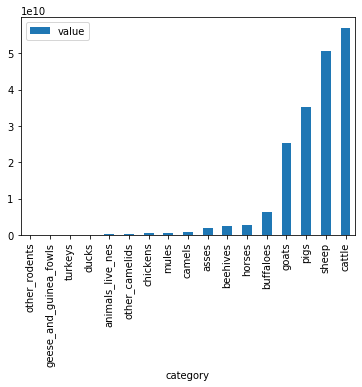

In [14]:
fao_fertilizer_df = pd.read_csv(fao_paths[0], encoding='latin-1')
world_animals = fao_fertilizer_df[fao_fertilizer_df.country_or_area == 'World +'][['value', 'category']]
world_animals.groupby('category', as_index=False).agg('sum').sort_values(by='value').plot.bar(x='category', y='value')

In [15]:
rice_prod_df = fao_crops_df[(fao_crops_df.category == 'rice_paddy') & (fao_crops_df.element == 'Production Quantity')]
rice_area_df = fao_crops_df[(fao_crops_df.category == 'rice_paddy') & (fao_crops_df.element == 'Area Harvested')]

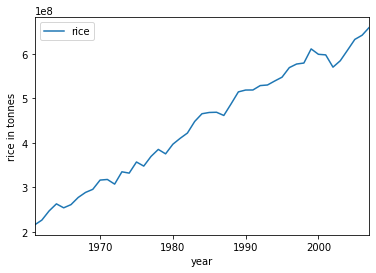

In [16]:
rice_prod_df[rice_prod_df.country_or_area == 'World +'][['year', 'value']].groupby('year').\
    agg(rice=('value', 'sum')).plot(label='rice')
plt.ylabel('rice in tonnes')
plt.legend()

In [17]:
continents = ['Africa +', 'Asia +', 'Americas +', 'Europe +', 'Oceania +']

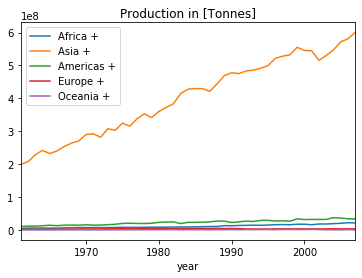

In [18]:
ax = plt.gca()
for continent in continents:
    rice_prod_df[rice_prod_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Production in [Tonnes]')

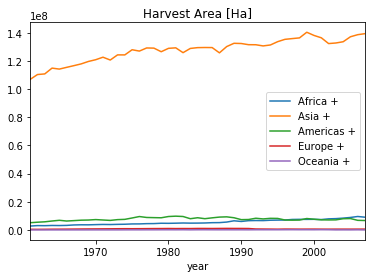

In [19]:
ax = plt.gca()
for continent in continents:
    rice_area_df[rice_area_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Harvest Area [Ha]')

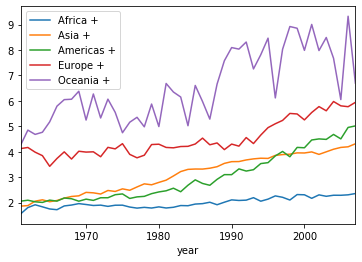

In [20]:
ax = plt.gca()
for continent in continents:
    efficiency_df = rice_prod_df[rice_prod_df.country_or_area == continent].groupby('year').agg('sum') / \
          rice_area_df[rice_area_df.country_or_area == continent].groupby('year').agg('sum')
    efficiency_df.plot(ax=ax)
    ax.legend(continents)

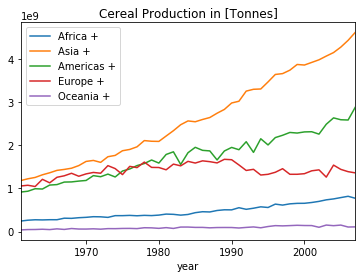

In [21]:
cereal_production_df = fao_crops_df[fao_crops_df.element == 'Production Quantity']
cereal_production_df = cereal_production_df[~cereal_production_df.category.str.contains('total')]
ax = plt.gca()
for continent in continents:
    cereal_production_df[cereal_production_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Cereal Production in [Tonnes]')

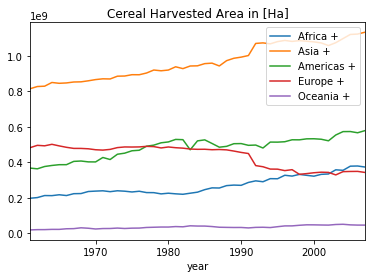

In [22]:
cereal_area_df = fao_crops_df[fao_crops_df.element == 'Area Harvested']
cereal_area_df = cereal_area_df[~cereal_area_df.category.str.contains('total')]
ax = plt.gca()
for continent in continents:
    cereal_area_df[cereal_area_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Cereal Harvested Area in [Ha]')

<Figure size 864x864 with 0 Axes>

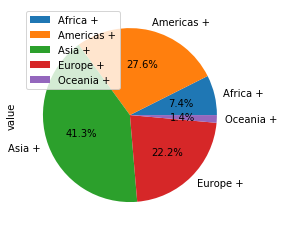

In [23]:
fig = plt.figure(figsize=(12, 12))
continent_production = cereal_production_df[(cereal_production_df.country_or_area.isin(continents)) & \
                                      (~cereal_production_df.category.str.contains('total'))]
continent_production[['country_or_area', 'value']].groupby('country_or_area').agg('sum')\
    .plot.pie(y='value', autopct='%1.1f%%')
plt.legend(loc='upper left')
plt.show()

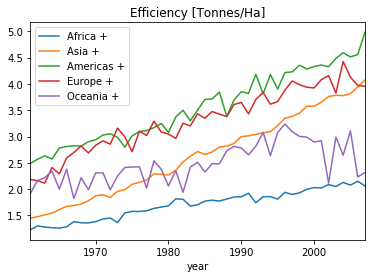

In [24]:
ax = plt.gca()
for continent in continents:
    efficiency_df = cereal_production_df[cereal_production_df.country_or_area == continent].groupby('year').agg('sum') / \
          cereal_area_df[cereal_area_df.country_or_area == continent].groupby('year').agg('sum')
    efficiency_df.plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Efficiency [Tonnes/Ha]')

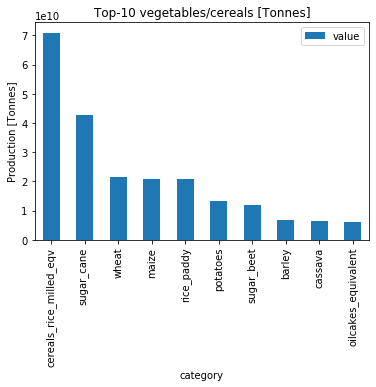

In [25]:
worlds_top_production = fao_crops_df[(fao_crops_df.country_or_area == 'World +') & \
                                     (fao_crops_df.element == 'Production Quantity')][['value', 'category']]
worlds_top_production = worlds_top_production[~worlds_top_production.category.str.contains('total')]
worlds_top_production = worlds_top_production.groupby('category', as_index=False).agg('sum').\
    sort_values(by='value', ascending=False).head(10)
worlds_top_production.plot.bar(x='category', y='value')
plt.title('Top-10 vegetables/cereals [Tonnes]')
plt.ylabel('Production [Tonnes]')
plt.show()

In [ ]:
list(filter(lambda x: 'total' in x, fao_crops_df.category.unique()))

In [ ]:
fao_crops_df.year.unique()